0
0


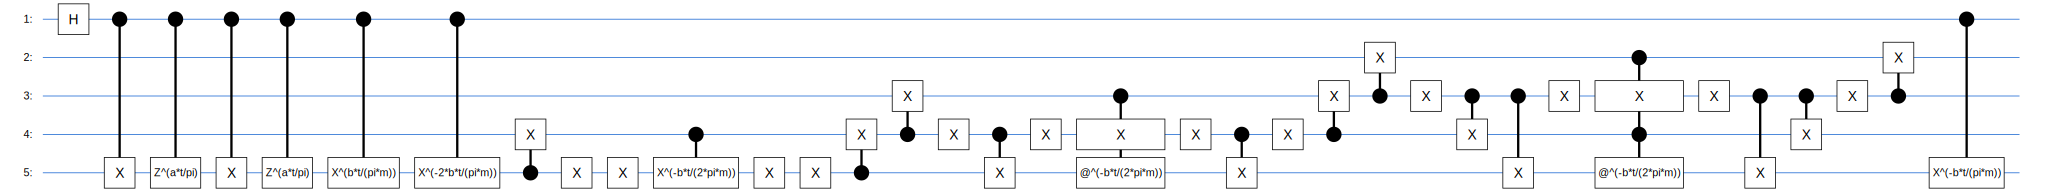

In [2]:
%reset -f


# Import the relevant libraries etc.

import cirq
from cirq.contrib.svg import SVGCircuit
from cirq.circuits import InsertStrategy


import sympy


# Set up the problem

a = 1
b = 2

# Eigenvalue register size
n_l = 1

# Problem Size
n_b = 4

# Number of Trotter Steps
m = 1








# Set up the registers

# Ancilla Qubit
anc = cirq.LineQubit(0)

# Eigenvalue register
q_l = []
for q in range(1,n_l + 1):
    q_l.append(cirq.LineQubit(q))
    
    
# Eigenvalue register
q_b = []
for q in range(n_l + 1,n_b + n_l + 1):
    q_b.append(cirq.LineQubit(q))



# Create the empty circuit
HHL_Circuit = cirq.Circuit()







# Put the Eigenvalue Register in Superposition
for q in q_l:
    HHL_Circuit.append(cirq.H(q))
    










    
    
    
    
    
    
    
    
    
    
# First we must loop over the eigenvalue bits
for l in reversed(range(n_l)):
    
    print(l)
    
    # Apply the first term, H1
    # The sequence of gates need not be repeated since the exponent can be taken into the Z gate
    HHL_Circuit.append([
        cirq.X(q_b[n_b-1]).controlled_by(q_l[l]),
        ((cirq.Z(q_b[n_b-1])**(sympy.Symbol('a')*sympy.Symbol('t')/sympy.pi)).controlled_by(q_l[l]))**(2**(n_l-1-l)),
        cirq.X(q_b[n_b-1]).controlled_by(q_l[l]),
        ((cirq.Z(q_b[n_b-1])**(sympy.Symbol('a')*sympy.Symbol('t')/sympy.pi)).controlled_by(q_l[l]))**(2**(n_l-1-l))
    ],strategy=InsertStrategy.NEW)
    
    
    # Apply the second term, a piece of H2
    HHL_Circuit.append(((cirq.X(q_b[n_b-1])**(2*sympy.Symbol('b')*sympy.Symbol('t')/sympy.pi/sympy.Symbol('m')/2)).controlled_by(q_l[l])),strategy=InsertStrategy.NEW)
    
    
    # This is the loop for the repetition part
    for i in range(2**(n_l-1-l)):
        for m_i in range(m):
            
            # Apply the third term, a piece of H2
            HHL_Circuit.append(((cirq.X(q_b[n_b-1])**(-2*sympy.Symbol('b')*sympy.Symbol('t')/sympy.pi/sympy.Symbol('m'))).controlled_by(q_l[l])),strategy=InsertStrategy.NEW)
            
            # Apply the fourth term, a piece of H3
            for j in range(1,n_b):
                # Here we construct each individual Cj
        
                # First identify the top and bottom qubit for this Cj
                bottom = n_b-1
                top = n_b-1 - j
                
                # Now apply the first operation the controlled not gate
                HHL_Circuit.append(cirq.CNOT(q_b[top+1],q_b[top]),strategy=InsertStrategy.NEW)
        
                # Now apply a not gate since we want to apply a series of not controlled nots
                HHL_Circuit.append(cirq.X(q_b[top+1]),strategy=InsertStrategy.NEW)
        
                # Start the loop to insert the bunch of not controlled nots
                for k in range(top+2, bottom + 1):
                    # Apply the controlled not operations
                    HHL_Circuit.append(cirq.CNOT(q_b[top + 1], q_b[k]),strategy=InsertStrategy.NEW)
        
        
                # Restore the qubit that we applied a not operation to 
                HHL_Circuit.append(cirq.X(q_b[top+1]),strategy=InsertStrategy.NEW)
        
        
                # Here we apply the gate with multiple controls
                gate = (cirq.X(q_b[top + 1])**(-sympy.Symbol('b')*sympy.Symbol('t')/sympy.pi/sympy.Symbol('m')/2)).controlled_by(q_b[top])
                for k in range(top + 2, bottom + 1):
                    gate = gate.controlled_by(q_b[k])
                HHL_Circuit.append(gate, strategy=InsertStrategy.NEW)
        
        
                # Apply a not gate again since we want to apply a series of not controlled nots
                HHL_Circuit.append(cirq.X(q_b[top+1]),strategy=InsertStrategy.NEW)
        
                # Start the loop to insert the bunch of not controlled nots
                for k in reversed(range(top+2, bottom + 1)):
                    # Apply the controlled not operations
                    HHL_Circuit.append(cirq.CNOT(q_b[top + 1], q_b[k]),strategy=InsertStrategy.NEW)
        
        
                # Restore the qubit that we applied a not operation to 
                HHL_Circuit.append(cirq.X(q_b[top+1]),strategy=InsertStrategy.NEW)
        
        
                # Apply the last operation, the controlled not gate
                HHL_Circuit.append(cirq.CNOT(q_b[top+1],q_b[top]),strategy=InsertStrategy.NEW)
        


        
                
                
                
    

    # Apply the fifth and last term, another piece of H2
    HHL_Circuit.append(((cirq.X(q_b[n_b-1])**(-2*sympy.Symbol('b')*sympy.Symbol('t')/sympy.pi/sympy.Symbol('m')/2)).controlled_by(q_l[l])),strategy=InsertStrategy.NEW)
    
    
    
    print(l)
        
        
        
# Check if the Circuit has been implemented as expected
SVGCircuit(HHL_Circuit)       